In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt               

In [2]:
dataset = dgl.data.CSVDataset('../../Dati/Dataset_otto_classi/')
dataset

Done loading data from cached files.


Dataset("Dataset_otto_classi", num_graphs=2276, save_path=../../Dati/Dataset_otto_classi/Dataset_otto_classi)

In [3]:
numer_class = []
a = 0
b = 0 
c = 0
d = 0
e = 0
f = 0
gg = 0
h = 0
for g, i in dataset:
    if i["label"].item() not in numer_class:
        numer_class.append(i["label"].item())
    if i["label"].item() == 0:
        a += 1
    elif i["label"].item() == 1:
        b += 1
    elif i["label"].item() == 2:
        c += 1
    elif i["label"].item() == 3:
        d += 1
    elif i["label"].item() == 4:
        e += 1
    elif i["label"].item() == 5:
        f += 1
    elif i["label"].item() == 6:
        gg += 1
    elif i["label"].item() == 7:
        h += 1

print(a, b, c, d, e, f, gg, h, (a+b+c+d+e+f+gg+h))
print(len(numer_class))

293 284 295 298 294 291 221 300 2276
8


In [4]:
dim_nfeats = 2
gclasses = len(numer_class)

In [5]:
size_batch = len(numer_class)*2
size_batch

16

In [6]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size= size_batch, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size= size_batch, drop_last=False)

In [7]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=3313, num_edges=118116,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), {'label': tensor([5., 4., 1., 2., 2., 1., 4., 6., 6., 1., 5., 7., 4., 0., 4., 1.])}]


In [8]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)

Number of nodes for each graph element in the batch: tensor([141, 358, 216, 249, 220, 107, 355,  40, 170, 213, 139,  33, 350, 143,
        360, 219])
Number of edges for each graph element in the batch: tensor([ 4570, 14432,  6870,  9422,  8456,  3384, 14332,  1072,  5222,  6796,
         4482,   456, 13600,  4652, 13368,  7002])
The original graphs in the minibatch:
[Graph(num_nodes=141, num_edges=4570,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=358, num_edges=14432,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=216, num_edges=6870,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=249, num_edges=9422,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=220, num_edges=8456,
      ndata_schemes={'label': Scheme(shape=(2,), dtype=torc

In [9]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        return dgl.mean_nodes(g, 'h')

In [10]:
if gclasses == 2:
    num_of_epoches = 200
elif gclasses >= 2:
    num_of_epoches = 1000

In [11]:
# Create the model with given dimensions
loss_scores = {}
controllo = []
min_valore = 0.45

model = GCN(dim_nfeats, 12, gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)



for epoch in range(num_of_epoches):
    print("Epoca: ", epoch)
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata['label'].float())
        loss = F.cross_entropy(pred, labels['label'].long())
        #print("epoca: ", epoch, loss)
        optimizer.zero_grad()
        #print(optimizer)
        loss.backward()
        #print(loss)
        optimizer.step()
        #print(optimizer)
    print("   Loss -> ", loss.item())
    loss_scores[epoch] = loss.item()
    """if loss.item() < 0.4 and epoch >= 400:
        break"""
    if loss.item() < min_valore:
        controllo.append((epoch, loss.item()))
    

Epoca:  0


/Applications/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


   Loss ->  2.064293622970581
Epoca:  1
   Loss ->  2.0271425247192383
Epoca:  2
   Loss ->  2.057941436767578
Epoca:  3
   Loss ->  1.9626102447509766
Epoca:  4
   Loss ->  2.032534599304199
Epoca:  5
   Loss ->  2.1204352378845215
Epoca:  6
   Loss ->  2.042412519454956
Epoca:  7
   Loss ->  1.9262218475341797
Epoca:  8
   Loss ->  1.9847995042800903
Epoca:  9
   Loss ->  1.9474819898605347
Epoca:  10
   Loss ->  1.9682022333145142
Epoca:  11
   Loss ->  2.028273820877075
Epoca:  12
   Loss ->  1.842291235923767
Epoca:  13
   Loss ->  1.98511803150177
Epoca:  14
   Loss ->  1.7687534093856812
Epoca:  15
   Loss ->  1.6355301141738892
Epoca:  16
   Loss ->  1.8713092803955078
Epoca:  17
   Loss ->  1.9185336828231812
Epoca:  18
   Loss ->  2.1401236057281494
Epoca:  19
   Loss ->  1.9895472526550293
Epoca:  20
   Loss ->  1.836085319519043
Epoca:  21
   Loss ->  1.9709945917129517
Epoca:  22
   Loss ->  1.7134875059127808
Epoca:  23
   Loss ->  1.7249428033828735
Epoca:  24
   Loss ->

   Loss ->  1.648354411125183
Epoca:  196
   Loss ->  1.4218449592590332
Epoca:  197
   Loss ->  1.7387056350708008
Epoca:  198
   Loss ->  1.7716468572616577
Epoca:  199
   Loss ->  1.6306490898132324
Epoca:  200
   Loss ->  1.474178671836853
Epoca:  201
   Loss ->  1.5796194076538086
Epoca:  202
   Loss ->  2.0070581436157227
Epoca:  203
   Loss ->  1.8197965621948242
Epoca:  204
   Loss ->  1.588985562324524
Epoca:  205
   Loss ->  1.5722899436950684
Epoca:  206
   Loss ->  1.27518892288208
Epoca:  207
   Loss ->  1.5141221284866333
Epoca:  208
   Loss ->  1.503870964050293
Epoca:  209
   Loss ->  1.8461354970932007
Epoca:  210
   Loss ->  1.481237530708313
Epoca:  211
   Loss ->  1.4411615133285522
Epoca:  212
   Loss ->  1.3313299417495728
Epoca:  213
   Loss ->  1.7419986724853516
Epoca:  214
   Loss ->  1.8694418668746948
Epoca:  215
   Loss ->  1.3616408109664917
Epoca:  216
   Loss ->  1.7028456926345825
Epoca:  217
   Loss ->  1.6234396696090698
Epoca:  218
   Loss ->  1.2021

   Loss ->  1.6017991304397583
Epoca:  388
   Loss ->  1.5419960021972656
Epoca:  389
   Loss ->  1.6311591863632202
Epoca:  390
   Loss ->  1.6464022397994995
Epoca:  391
   Loss ->  1.7384320497512817
Epoca:  392
   Loss ->  1.591568946838379
Epoca:  393
   Loss ->  1.3902063369750977
Epoca:  394
   Loss ->  1.708865761756897
Epoca:  395
   Loss ->  1.2634974718093872
Epoca:  396
   Loss ->  1.386945366859436
Epoca:  397
   Loss ->  1.764492392539978
Epoca:  398
   Loss ->  1.2549898624420166
Epoca:  399
   Loss ->  1.645983099937439
Epoca:  400
   Loss ->  1.9195728302001953
Epoca:  401
   Loss ->  1.4679867029190063
Epoca:  402
   Loss ->  1.8686327934265137
Epoca:  403
   Loss ->  1.5745919942855835
Epoca:  404
   Loss ->  1.5014926195144653
Epoca:  405
   Loss ->  1.6509222984313965
Epoca:  406
   Loss ->  1.604025959968567
Epoca:  407
   Loss ->  1.5376782417297363
Epoca:  408
   Loss ->  1.6491082906723022
Epoca:  409
   Loss ->  1.6005934476852417
Epoca:  410
   Loss ->  1.646

   Loss ->  1.72792387008667
Epoca:  580
   Loss ->  1.4021707773208618
Epoca:  581
   Loss ->  1.9018478393554688
Epoca:  582
   Loss ->  1.7998768091201782
Epoca:  583
   Loss ->  1.513628363609314
Epoca:  584
   Loss ->  2.543606996536255
Epoca:  585
   Loss ->  1.6918193101882935
Epoca:  586
   Loss ->  1.6686419248580933
Epoca:  587
   Loss ->  1.0399762392044067
Epoca:  588
   Loss ->  2.108574628829956
Epoca:  589
   Loss ->  1.5640181303024292
Epoca:  590
   Loss ->  2.0735538005828857
Epoca:  591
   Loss ->  1.6177107095718384
Epoca:  592
   Loss ->  1.734228491783142
Epoca:  593
   Loss ->  1.7497652769088745
Epoca:  594
   Loss ->  1.608397126197815
Epoca:  595
   Loss ->  1.581274151802063
Epoca:  596
   Loss ->  1.5388307571411133
Epoca:  597
   Loss ->  1.9211608171463013
Epoca:  598
   Loss ->  1.181260347366333
Epoca:  599
   Loss ->  1.3379193544387817
Epoca:  600
   Loss ->  2.119917631149292
Epoca:  601
   Loss ->  1.8472299575805664
Epoca:  602
   Loss ->  1.8182319

   Loss ->  1.867462158203125
Epoca:  772
   Loss ->  1.6645094156265259
Epoca:  773
   Loss ->  1.4993022680282593
Epoca:  774
   Loss ->  1.7203665971755981
Epoca:  775
   Loss ->  1.498741626739502
Epoca:  776
   Loss ->  1.7343825101852417
Epoca:  777
   Loss ->  1.4905580282211304
Epoca:  778
   Loss ->  1.7847217321395874
Epoca:  779
   Loss ->  1.3571840524673462
Epoca:  780
   Loss ->  1.6728171110153198
Epoca:  781
   Loss ->  2.0584499835968018
Epoca:  782
   Loss ->  1.4017168283462524
Epoca:  783
   Loss ->  1.5231600999832153
Epoca:  784
   Loss ->  1.2222338914871216
Epoca:  785
   Loss ->  1.8045634031295776
Epoca:  786
   Loss ->  1.68107271194458
Epoca:  787
   Loss ->  1.6466859579086304
Epoca:  788
   Loss ->  1.345037579536438
Epoca:  789
   Loss ->  1.434822916984558
Epoca:  790
   Loss ->  1.4563850164413452
Epoca:  791
   Loss ->  1.4920262098312378
Epoca:  792
   Loss ->  1.2178806066513062
Epoca:  793
   Loss ->  1.718921184539795
Epoca:  794
   Loss ->  1.5025

   Loss ->  1.7499213218688965
Epoca:  964
   Loss ->  1.636818289756775
Epoca:  965
   Loss ->  1.4626868963241577
Epoca:  966
   Loss ->  1.6000441312789917
Epoca:  967
   Loss ->  1.4157527685165405
Epoca:  968
   Loss ->  1.629025936126709
Epoca:  969
   Loss ->  1.6366263628005981
Epoca:  970
   Loss ->  1.5046879053115845
Epoca:  971
   Loss ->  1.5629476308822632
Epoca:  972
   Loss ->  1.3245900869369507
Epoca:  973
   Loss ->  1.3575186729431152
Epoca:  974
   Loss ->  1.639332890510559
Epoca:  975
   Loss ->  1.4773389101028442
Epoca:  976
   Loss ->  1.5152190923690796
Epoca:  977
   Loss ->  1.7718614339828491
Epoca:  978
   Loss ->  1.321327805519104
Epoca:  979
   Loss ->  1.7580591440200806
Epoca:  980
   Loss ->  1.7717140913009644
Epoca:  981
   Loss ->  1.67759370803833
Epoca:  982
   Loss ->  1.6382840871810913
Epoca:  983
   Loss ->  1.4386930465698242
Epoca:  984
   Loss ->  1.3674479722976685
Epoca:  985
   Loss ->  1.6384261846542358
Epoca:  986
   Loss ->  1.399

In [12]:
print("Ultmia epoca ", epoch," con valore di loss ->", loss.item())

Ultmia epoca  999  con valore di loss -> 1.812350869178772


In [13]:
for x in controllo:
    if x[1] < 0.45:
        print(x)

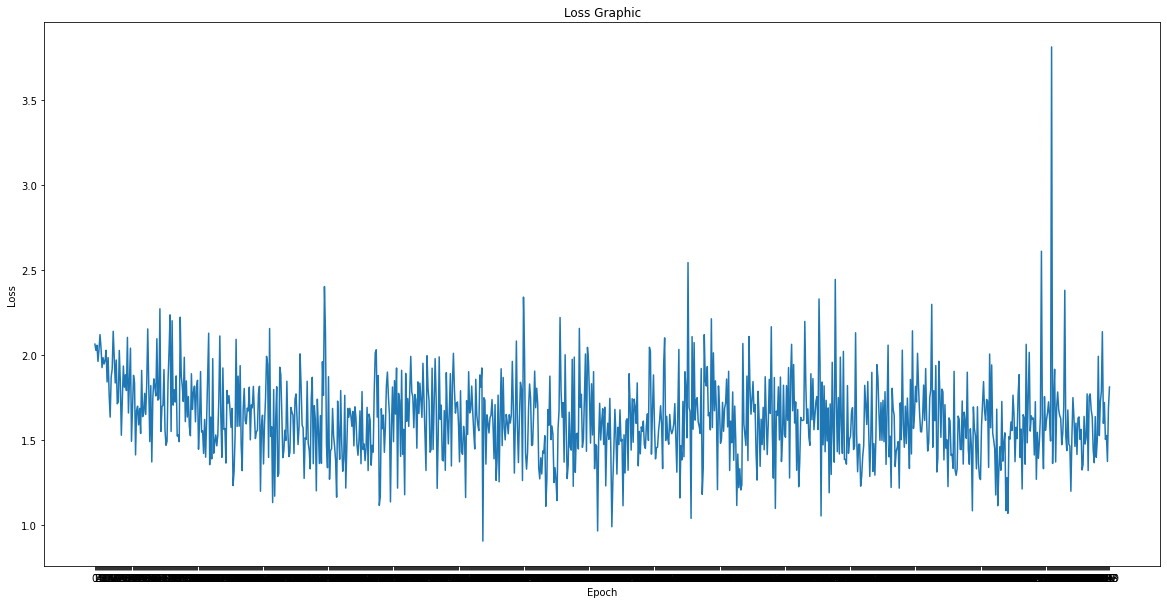

In [14]:
plt.figure(figsize = (20,10))
plt.plot(loss_scores.values())
plt.xticks(range(0,num_of_epoches,1), loss_scores.keys())
plt.title("Loss Graphic")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [15]:
num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['label'].float())
    num_correct += (pred.argmax(1) == labels['label'].long()).sum().item()
    num_tests += len(labels['label'].long())
    
    
print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.36622807017543857


## Analisi risultati
Con il dataset Binario l'accuratezza si aggira attorno al 0.9.
Con il dataset Multiplo il quale momentaneamente contiene 4 classi di grafi l'accuratezza si aggira attorno al 0.54.

## PROVE


Numero di nodi 16

batch = 10 epoche 1000 con soglia 400epoche e loss < 0.4 -> ***ACCURATEZZA OTTENUTA*** 0,61

batch = 8 epoche 5000  -> ***ACCURATEZZA OTTENUTA*** 0,61 con ultima loss -> 0.7

batch = 8 epoche 1000  -> ***ACCURATEZZA OTTENUTA*** 0,59 con ultima loss -> 0.87

batch = 8 epoche 1000  -> ***ACCURATEZZA OTTENUTA*** 0,63 con ultima loss -> 1.61





Numero di nodi 32

batch = 8 epoche 1000 ->  ***ACCURATEZZA OTTENUTA*** 0,62 con ultima loss ->  1.09


Numero di nodi 12

batch = 8 epoche 1000 ->  ***ACCURATEZZA OTTENUTA*** 0,62 con ultima loss ->   0.75







Numero di nodi 12 classificazione di sei classi 

batch = 12 epoche 1000 -> ***ACCURATEZZA OTTENUTA*** 0,42 con ultima loss ->  0.84